In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# -*- coding: utf-8 -*-

# https://teddykoker.com/2020/12/dataloader/

import sys
sys.path.append("/home/rkube/repos/frnn-loader")

from os.path import join
from pathlib import Path

import numpy as np
import yaml
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt

from frnn_loader.backends.fetchers import fetcher_d3d_v1
from frnn_loader.backends.backend_hdf5 import backend_hdf5
from frnn_loader.primitives.filters import filter_ip_thresh
from frnn_loader.primitives.resamplers import resampler_causal
from frnn_loader.primitives.signal import signal_0d
from frnn_loader.primitives.normalizers import mean_std_normalizer
from frnn_loader.loaders.frnn_dataset_disk import shot_dataset_disk
from frnn_loader.loaders.frnn_multi_dataset import frnn_multi_dataset

from frnn_loader.utils.errors import SignalCorruptedError, NotDownloadedError

Construct a dataset for FRNN training.

Predictive machine learning models are trained on datasets. These dataset
consist of a suite of measurements taken on a set of shots.

Deep neural networks are trained on pre-processed and normalized data.
Pre-processing includes:
- Resampling of the measurements onto a common time-base
- Construction of target variables, such as time-to-disruption or time-to-ELM
- Signal clipping
- Calculating and applying normalization

Normalization means the transformation of signals into order unity quantities. Common ways
to do this is by a Z-score transformation (subtract mean, divide by std dev.), min/max normalizer,
etc.

In [6]:
# Directory where all project data files are to be stored
root = "/projects/FRNN/frnn_loader"

# 1/ Describe the dataset
predictor_tags = [
    "q95",
    "efsli",
    "ipspr15V",
    "efsbetan",
    "efswmhd",
    "dssdenest",
    "pradcore",
    "pradedge",
    "bmspinj",
    "bmstinj",
    "ipsiptargt",
    "ipeecoil",
]
predictor_list = [signal_0d(tag) for tag in predictor_tags]

# Contains a list of shots that are non-disruptive
shotlist_clear = "d3d_clear_100.txt"
# Contains a list of shots that are disruptive
shotlist_disrupt = "d3d_disrupt_100.txt"

In [7]:
# Instantiate the filter we use to crimp the shot times
ip_filter = filter_ip_thresh(0.2, abs=True)
signal_ip = signal_0d("ipspr15V")
my_backend = backend_hdf5(root)
my_fetcher = fetcher_d3d_v1()

# These shots don't have enough data and are unusable
# Several of them are also not disruptive but die to to carbon motes or other hardware failures
skip_shots = [167548, 168439, 168441, 168450, 168484, 168500, 168442, 168443, 168483, 168485, 168486]

In [8]:
shotdict = {}

with open(join(root, "..", "shot_lists", shotlist_clear), "r") as fp:
    for line in fp.readlines():
        # Convert shotnr to int and ttd to float
        shotnr, ttd = [trf(val) for trf, val in zip([int, float], line.split())]
        
        # Run the Ip filter over the current shot.
        # For this we need the shot raw-data. Ask the backend to load it.
        try:
            tb, signal_data = my_backend.load(signal_ip.info, shotnr)
        except NotDownloadedError:
            # IF it's now downloaded a NotDownloadedError is thrown.
            # Then use the fetcher to manually download it
            tb, _, signal_data, _, _, _ = my_fetcher.fetch(signal_ip.info, shotnr)
            my_backend.store(signal_ip.info, shotnr, tb, signal_data)
        # Some shots in d3d_clear_100 have no plasma. Skip these shots.
        print(shotnr)
        if shotnr in skip_shots:
            continue
        try:
            tmin, tmax = ip_filter(tb, signal_data)
        except SignalCorruptedError as err:
            print(f"--- Shot {shotnr}: Error: ", err)
            continue
            
        shotdict.update(
            {
                shotnr: {
                    "tmin": tmin,
                    "tmax": tmax,
                    "is_disruptive": False,
                    "t_disrupt": -1.0,
                }
            }
        )

167475
167481
167482
167483
167484
167485
167486
167489
167490
167491
167493
167495
167499
167502
167504
167506
167515
--- Shot 167515: Error:  Bad signal
167516
167517
167518
167519
167520
167521
167522
167523
167524
167525
167526
167527
167528
167529
167530
167531
167532
167533
167534
167535
167536
167537
167538
167539
167540
167541
167542
167547
167548
167549
167551
167552
167553
167554
167555
167563
167567
167568
167569
167570
167571
167572
167574
167575
167576
167577
167578
167579
167580
167589
167600
167601
167602
167603
167605
167606
167607
167608
167618
168439
168440
--- Shot 168440: Error:  Bad signal
168441
168444
--- Shot 168444: Error:  Bad signal
168450
168451
168484
168487
--- Shot 168487: Error:  Bad signal
168488
--- Shot 168488: Error:  Bad signal
168490
--- Shot 168490: Error:  Bad signal
168491
--- Shot 168491: Error:  Bad signal
168500
168504
168516
168519
168529
168530
168534
168536
168537
168544
168548
168551
168554


In [9]:
with open(join(root, "..", "shot_lists", shotlist_disrupt), "r") as fp:
    for line in fp.readlines():
        # Convert shotnr to int and ttd to float
        shotnr, ttd = [trf(val) for trf, val in zip([int, float], line.split())]
        
        # Run the Ip filter over the current shot.
        # For this we need the shot raw-data. Ask the backend to load it.
        try:
            tb, signal_data = my_backend.load(signal_ip.info, shotnr)
        except NotDownloadedError:
            # IF it's now downloaded a NotDownloadedError is thrown.
            # Then use the fetcher to manually download it
            tb, _, signal_data, _, _, _ = my_fetcher.fetch(signal_ip.info, shotnr)
            my_backend.store(signal_ip.info, shotnr, tb, signal_data)
        
        if shotnr in skip_shots:
            continue
        # ttd is given in seconds in the text files. Convert it to milliseconds
        ttd = ttd * 1e3
        shotdict.update(
            {
                shotnr: {
                    "tmin": tmin,
                    "tmax": ttd,
                    "is_disruptive": True,
                    "t_disrupt": ttd,
                }
            }
        )


In [10]:
#########################################################################################################
#
# Next we create a list of datasets for all shots.
# The shots are cut to the time intervals defined by tmin and tmax
# A normalizer is calculated from these datasets.
# After the normalizer has been calculated the hdf5 files generated by
# these dataset are to be deleted using ds.delete_data_file

dset_unnormalized_list = []
for shotnr in tqdm(shotdict.keys()):
    # Resample all signals over the valid intervals
    my_resampler = resampler_causal(0.0, shotdict[shotnr]["tmax"], 1.0)

    ds = shot_dataset_disk(
        shotnr,
        predictors=predictor_list,
        resampler=my_resampler,
        backend_file=my_backend,
        fetcher=my_fetcher,
        root=root,
        download=True,
        normalizer=None,
        is_disruptive=shotdict[shotnr]["is_disruptive"],
        dtype=torch.float32)

    dset_unnormalized_list.append(ds)

100%|██████████████████████████████████████████████████████████████████████████| 182/182 [01:55<00:00,  1.58it/s]


In [12]:
dset_unnormalized_list[0].tmp_fname

'/projects/FRNN/frnn_loader/0fgzvxyf.h5'

In [11]:
#########################################################################################################
#
# With all datasets cropped to the correct time in place we continue by calculating the normalization.
# Do this using multi-processing
my_normalizer = mean_std_normalizer()
my_normalizer.fit(dset_unnormalized_list)

print(my_normalizer.mean_all)
print(my_normalizer.std_all)

tensor([ 5.5796e+00,  1.0363e+00,  1.2799e+00,  1.1793e+00,  4.3489e+05,
         3.0479e+00,  1.4923e-03,  7.7360e-04,  4.0111e+03,  2.6452e+00,
         1.9483e+00, -3.5770e-02])
tensor([2.3674e+00, 2.0656e+00, 1.5536e+00, 1.0112e+00, 3.2865e+05, 1.5294e+00,
        1.8120e-03, 9.1452e-04, 2.8319e+03, 2.4800e+00, 6.2479e-01, 1.1830e-01])


In [14]:
np.random.randint(10)

NameError: name 'np' is not defined

In [12]:
# Print mean and standard deviation for unnormalized datasets 
for ds in dset_unnormalized_list:
    print(ds[:][0].shape, ds[:][0].mean(axis=0), ds[:][0].std(axis=0))

torch.Size([6234, 12]) tensor([ 6.2397e+00,  9.7653e-01,  1.7384e+00,  1.8166e+00,  6.2798e+05,
         3.0376e+00,  1.8857e-03,  1.3896e-03,  5.6089e+03,  4.3848e+00,
         1.7696e+00, -3.5331e-02]) tensor([1.4428e+00, 3.8160e-01, 4.3369e-01, 1.0206e+00, 3.7188e+05, 1.0748e+00,
        1.6551e-03, 9.2308e-04, 3.3695e+03, 2.6507e+00, 4.0958e-01, 8.1703e-02])
torch.Size([6456, 12]) tensor([ 6.3304e+00,  9.5908e-01,  1.7055e+00,  1.7223e+00,  5.9248e+05,
         3.5379e+00,  2.2489e-03,  1.1336e-03,  6.2639e+03,  5.0638e+00,
         1.7213e+00, -1.9438e-02]) tensor([1.3597e+00, 3.2436e-01, 4.5833e-01, 1.1209e+00, 3.8976e+05, 1.4991e+00,
        2.3117e-03, 7.9456e-04, 4.3591e+03, 3.5988e+00, 4.7794e-01, 3.4468e-02])
torch.Size([6446, 12]) tensor([ 6.2318e+00,  9.8198e-01,  1.7139e+00,  1.7978e+00,  6.1599e+05,
         3.2425e+00,  1.9478e-03,  1.2806e-03,  6.1516e+03,  4.9985e+00,
         1.7236e+00, -1.3393e-02]) tensor([1.3552e+00, 3.8591e-01, 4.5194e-01, 1.2057e+00, 4.1085e+05

torch.Size([6123, 12]) tensor([ 5.2681e+00,  9.2912e-01,  1.8436e+00,  1.2466e+00,  4.4522e+05,
         3.8352e+00,  1.1405e-03,  5.9938e-04,  3.1668e+03,  2.6442e+00,
         1.8550e+00, -1.1428e-02]) tensor([1.5837e+00, 2.9597e-01, 5.6329e-01, 6.1530e-01, 2.5750e+05, 1.4866e+00,
        6.5430e-04, 3.6839e-04, 1.9755e+03, 1.7459e+00, 5.8034e-01, 4.8171e-02])
torch.Size([6148, 12]) tensor([ 5.2652e+00,  9.2667e-01,  1.8367e+00,  1.2178e+00,  4.3354e+05,
         3.8393e+00,  1.1425e-03,  5.5392e-04,  3.1460e+03,  2.6277e+00,
         1.8475e+00, -1.0789e-02]) tensor([1.5969e+00, 3.0991e-01, 5.7061e-01, 5.9636e-01, 2.4961e+05, 1.4651e+00,
        6.2045e-04, 3.3334e-04, 1.9801e+03, 1.7494e+00, 5.9107e-01, 5.0792e-02])
torch.Size([6152, 12]) tensor([ 5.2246e+00,  9.2197e-01,  1.8370e+00,  1.2837e+00,  4.6126e+05,
         3.9538e+00,  9.4660e-04,  5.2417e-04,  3.1414e+03,  2.6239e+00,
         1.8463e+00, -9.2860e-03]) tensor([1.4721e+00, 2.9247e-01, 5.7209e-01, 6.2535e-01, 2.6212e+05

torch.Size([6052, 12]) tensor([ 4.6620e+00,  1.0377e+00,  2.1291e+00,  1.1068e+00,  4.5232e+05,
         3.5782e+00,  7.8016e-04,  5.6308e-04,  2.6410e+03,  2.1843e+00,
         2.1594e+00, -3.0275e-02]) tensor([1.7537e+00, 5.4997e-01, 6.6418e-01, 6.6602e-01, 3.1368e+05, 1.3070e+00,
        4.4197e-04, 3.1696e-04, 2.0080e+03, 1.6454e+00, 6.7796e-01, 4.3902e-02])
torch.Size([3750, 12]) tensor([ 4.1018e+00,  1.3951e+00,  2.6140e+00,  1.0589e+00,  5.8405e+05,
         4.1598e+00,  1.0199e-03,  7.3000e-04,  3.7077e+03,  3.0759e+00,
         2.6706e+00, -5.6639e-02]) tensor([1.4980e+00, 2.6033e+01, 6.5608e-01, 7.6032e+00, 1.3914e+06, 1.5842e+00,
        1.7054e-03, 3.1850e-04, 1.2560e+03, 1.0023e+00, 6.3535e-01, 1.1419e-01])
torch.Size([6449, 12]) tensor([ 4.0987e+00,  9.8038e-01,  2.3572e+00,  1.2261e+00,  5.5647e+05,
         4.0594e+00,  1.2861e-03,  4.8194e-04,  2.7915e+03,  2.2457e+00,
         2.3969e+00, -3.9614e-02]) tensor([1.4168e+00, 3.6717e-01, 7.4917e-01, 6.8177e-01, 3.7637e+05

torch.Size([3092, 12]) tensor([ 6.5619e+00,  1.8617e+00,  1.1913e+00,  6.3741e-01,  1.6414e+05,
         7.1157e-01,  9.7804e-04,  2.5282e-05,  6.8113e+02, -8.4597e-02,
         1.2448e+00, -5.3483e-02]) tensor([2.6228e+00, 7.9956e+00, 5.2531e-01, 3.9146e+00, 2.6217e+05, 2.3838e-01,
        6.8305e-04, 5.0999e-05, 9.5019e+02, 8.1218e-01, 5.2600e-01, 6.7474e-02])
torch.Size([6805, 12]) tensor([ 4.3511e+00,  1.1744e+00,  1.7784e+00,  9.6632e-01,  2.8947e+05,
         3.4404e+00,  2.3486e-03,  2.2875e-04,  3.9650e+03,  5.8871e-01,
         1.8027e+00, -2.4313e-02]) tensor([1.2034e+00, 8.0814e-01, 4.1155e-01, 9.5543e-01, 1.1722e+05, 1.0924e+00,
        8.1709e-04, 3.1048e-04, 1.5915e+03, 1.2466e+00, 4.0528e-01, 4.2267e-02])
torch.Size([7089, 12]) tensor([ 5.9344e+00,  1.3974e+00,  1.7338e+00,  6.2477e-01,  1.9909e+05,
         2.7491e+00,  1.0884e-03,  1.6506e-04,  2.0866e+03,  3.8215e-01,
         1.7679e+00, -3.4111e-02]) tensor([1.3748e+00, 1.9589e-01, 4.1496e-01, 2.0226e-01, 6.6014e+04

torch.Size([5222, 12]) tensor([ 4.0411e+00,  7.8340e-01,  2.6138e+00,  1.7642e+00,  8.4179e+05,
         4.2114e+00,  2.7120e-03,  9.5213e-04,  6.1148e+03,  4.9312e+00,
         2.6554e+00, -4.1632e-02]) tensor([1.2366e+00, 6.7410e-02, 5.1905e-01, 6.8838e-01, 3.7882e+05, 1.4462e+00,
        2.2577e-03, 4.5829e-04, 2.5992e+03, 1.9776e+00, 4.9543e-01, 6.5367e-02])
torch.Size([4383, 12]) tensor([ 4.1107e+00,  8.2528e-01,  2.5731e+00,  1.4130e+00,  6.6608e+05,
         3.4071e+00,  1.6540e-03,  9.8928e-04,  5.2096e+03,  4.0775e+00,
         2.6167e+00, -4.3613e-02]) tensor([1.3462e+00, 8.8179e-02, 5.5072e-01, 5.4621e-01, 3.0322e+05, 1.3782e+00,
        1.4552e-03, 5.1657e-04, 2.1838e+03, 1.5675e+00, 5.2990e-01, 5.4236e-02])
torch.Size([883, 12]) tensor([ 6.3425e+00,  8.9309e-01,  1.5751e+00,  4.8903e-01,  1.3914e+05,
         2.5021e+00,  1.9245e-03,  5.4669e-04,  2.0352e+03,  1.8896e+00,
         1.6929e+00, -1.1785e-01]) tensor([1.6171e+00, 1.7822e-01, 4.9877e-01, 2.9375e-01, 8.0371e+04,

torch.Size([4916, 12]) tensor([ 5.5411e+00,  8.6954e-01,  2.0229e+00,  1.8492e+00,  7.7059e+05,
         3.6717e+00,  1.0566e-03,  2.3744e-03,  6.9431e+03,  5.6378e+00,
         2.0590e+00, -3.6044e-02]) tensor([1.1356e+00, 9.4933e-02, 3.3353e-01, 1.1168e+00, 4.7833e+05, 1.3782e+00,
        7.4004e-04, 1.7140e-03, 4.9711e+03, 4.0333e+00, 3.1068e-01, 6.0808e-02])
torch.Size([4590, 12]) tensor([ 5.5882e+00,  8.5379e-01,  2.0170e+00,  1.9223e+00,  7.9821e+05,
         3.4551e+00,  1.2733e-03,  2.3619e-03,  7.1523e+03,  5.7980e+00,
         2.0504e+00, -3.3387e-02]) tensor([1.1652e+00, 9.4675e-02, 3.4363e-01, 1.1608e+00, 4.9582e+05, 1.5715e+00,
        2.2522e-03, 1.6978e-03, 4.8663e+03, 3.9398e+00, 3.1979e-01, 5.9971e-02])
torch.Size([2778, 12]) tensor([ 5.7908e+00,  8.9410e-01,  1.9222e+00,  1.2049e+00,  4.9274e+05,
         3.0244e+00,  8.8868e-04,  1.1470e-03,  4.4243e+03,  2.9958e+00,
         1.9661e+00, -4.3931e-02]) tensor([1.4757e+00, 1.1677e-01, 4.1467e-01, 1.0008e+00, 4.2749e+05

torch.Size([2955, 12]) tensor([ 6.7941e+00,  1.2136e+00,  1.7564e+00,  1.0595e+00,  3.7301e+05,
         2.8598e+00,  1.4971e-03,  4.6416e-04,  5.0973e+03,  1.2252e+00,
         1.7836e+00, -2.7241e-02]) tensor([2.2654e+00, 1.4150e-01, 4.1991e-01, 2.4229e-01, 1.1742e+05, 9.1928e-01,
        1.8641e-03, 2.0357e-04, 1.5976e+03, 7.9303e-01, 3.8002e-01, 7.3715e-02])
torch.Size([6267, 12]) tensor([ 6.0668e+00,  1.2553e+00,  1.8515e+00,  1.1018e+00,  3.9404e+05,
         3.0888e+00,  1.2497e-03,  4.4039e-04,  5.2730e+03,  1.2725e+00,
         1.8696e+00, -1.8132e-02]) tensor([1.4186e+00, 2.8253e-01, 3.2808e-01, 3.5797e-01, 1.0930e+05, 8.2787e-01,
        3.1901e-04, 2.5770e-04, 1.9447e+03, 1.4339e+00, 3.1359e-01, 4.7528e-02])
torch.Size([941, 12]) tensor([ 1.2476e+01,  1.2792e+00,  6.3159e-01,  3.9223e-01,  4.2214e+04,
         8.9525e-01,  5.7457e-04,  3.6771e-05,  2.5639e+02,  9.7855e-02,
         1.3226e+00, -6.9102e-01]) tensor([5.1088e+00, 4.2219e-01, 2.4247e-01, 2.9925e-01, 3.0648e+04,

torch.Size([6142, 12]) tensor([ 5.8350e+00,  1.0654e+00,  1.8636e+00,  1.2134e+00,  4.4139e+05,
         4.0332e+00,  8.7317e-04,  1.8619e-03,  3.2970e+03,  1.3714e+00,
         1.8810e+00, -1.7422e-02]) tensor([9.0693e-01, 1.8937e-01, 3.1524e-01, 4.9179e-01, 1.4961e+05, 1.0456e+00,
        3.4749e-04, 7.4512e-04, 1.0555e+03, 1.2152e+00, 2.9440e-01, 5.4285e-02])
torch.Size([6704, 12]) tensor([ 5.8960e+00,  1.1457e+00,  1.8155e+00,  1.3222e+00,  4.6429e+05,
         3.9219e+00,  8.9645e-04,  2.0815e-03,  4.1086e+03,  1.9699e+00,
         1.8319e+00, -1.6341e-02]) tensor([1.0398e+00, 3.6052e-01, 3.6164e-01, 4.2278e-01, 1.7757e+05, 1.0967e+00,
        2.5871e-04, 9.0880e-04, 1.5019e+03, 1.6275e+00, 3.4567e-01, 5.0659e-02])


In [13]:
# With a normalizer at hand, we can now safely delete the datafiles from the
# un-normalized shots.
# Then re-instantiate the datasets using the trained normalizer
dset_normalized_list = []
for shotnr in tqdm(shotdict.keys()):
    print(shotnr)

    # Resample all signals over the valid intervals
    my_resampler = resampler_causal(0.0, shotdict[shotnr]["tmax"], 1.0)

    ds = shot_dataset_disk(
        shotnr,
        predictors=predictor_list,
        resampler=my_resampler,
        backend_file=my_backend,
        fetcher=my_fetcher,
        root=root,
        download=True,
        normalizer=my_normalizer,
        is_disruptive=shotdict[shotnr]["is_disruptive"],
        dtype=torch.float32,
    )
    dset_normalized_list.append(ds)

dset_all = frnn_multi_dataset(dset_normalized_list)

167475
167481
167482
167483
167484
167485
167486
167489
167490
167491
167493
167495
167499
167502
167504
167506
167516
167517
167518
167519
167520
167521
167522
167523
167524
167525
167526
167527
167528
167529
167530
167531
167532
167533
167534
167535
167536
167537
167538
167539
167540
167541
167542
167547
167549
167551
167552
167553
167554
167555
167563
167567
167568
167569
167570
167571
167572
167574
167575
167576
167577
167578
167579
167580
167589
167600
167601
167602
167603
167605
167606
167607
167608
167618
168451
168504
168516
168519
168529
168530
168534
168536
168537
168544
168548
168551
168554
167480
167487
167488
167492
167494
167496
167497
167498
167500
167501
167503
167505
167550
167556
167557
167558
167559
167560
167561
167562
167564
167565
167566
167586
167587
167588
167590
167591
167592
167593
167594
167595
167596
167597
167598
167599
167610
167611
167612
167613
167614
167615
167616
167617
167619
167621
167622
168445
168446
168447
168448
168449
168489
168492
168493
168494

In [33]:
dset_all[16]

In [50]:
idx_list = np.random.permutation(100)[:5]

for i in idx_list:
    print(dset_all[i][:][0].mean(axis=0))
    print(dset_all[i][:][0].std(axis=0))

TypeError: 'NoneType' object is not subscriptable

## Plot results of normalization

In [57]:
len(dset_unnormalized_list), len(dset_all.ds_list)

rand_idx = np.random.permutation(len(dset_unnormalized_list))[:5]

IndexError: list index out of range

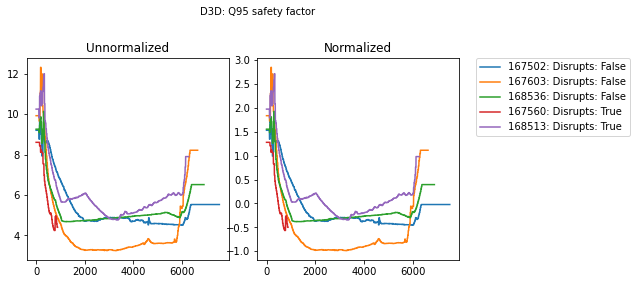

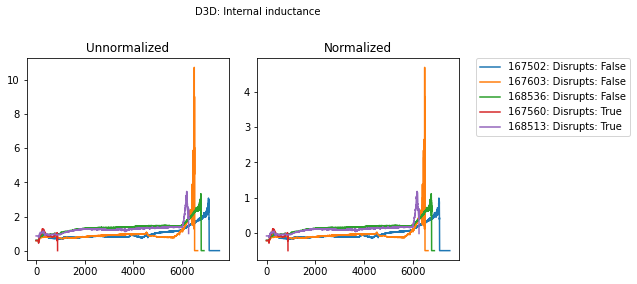

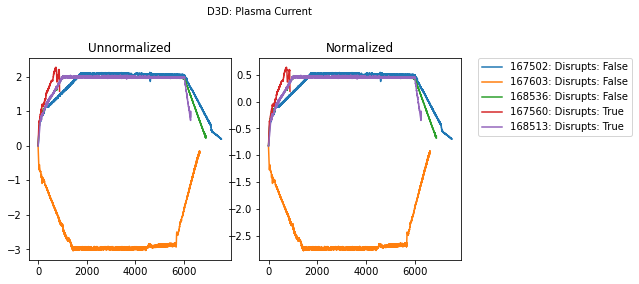

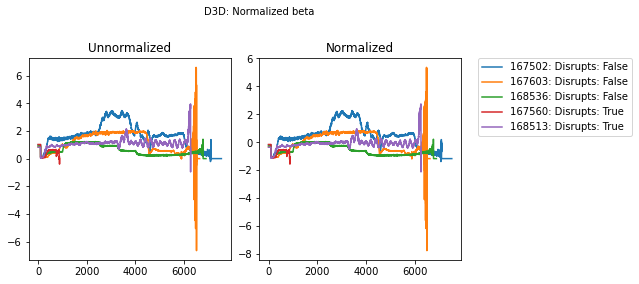

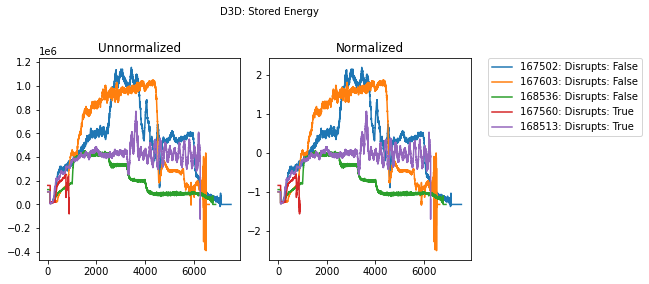

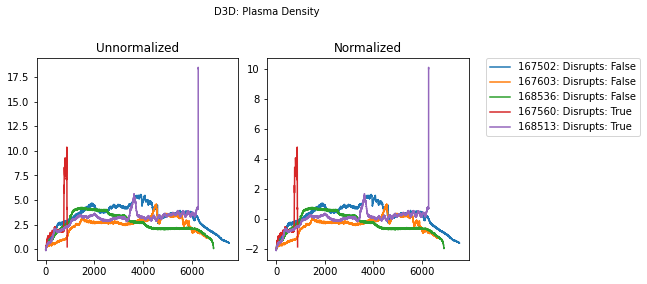

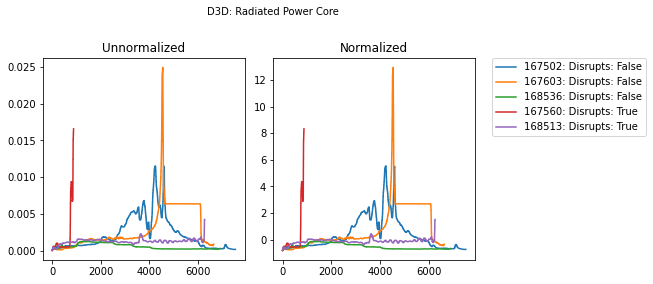

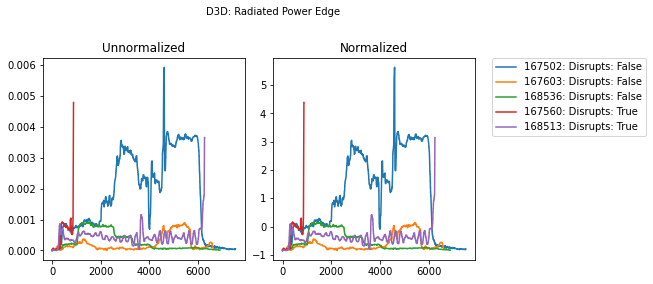

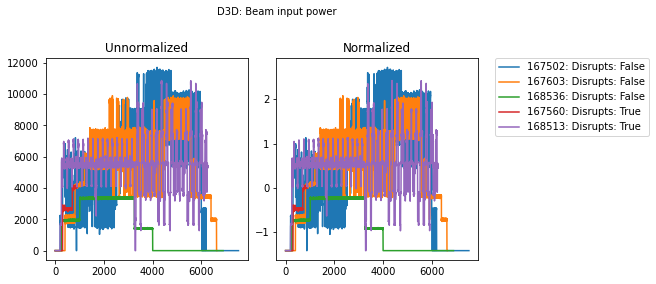

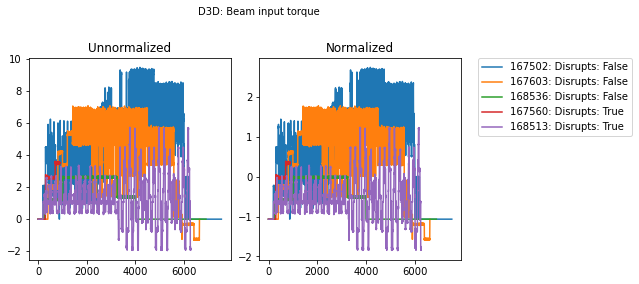

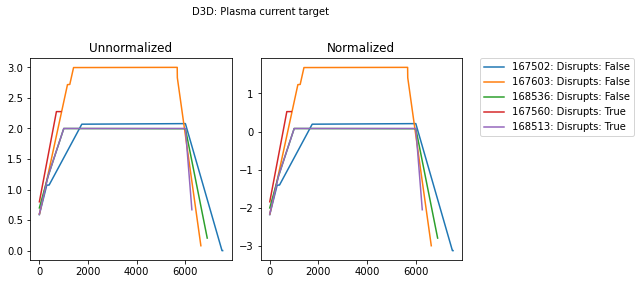

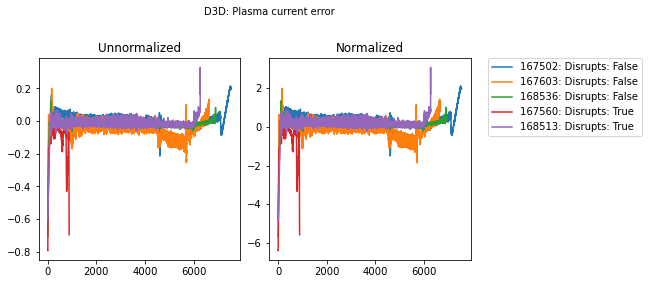

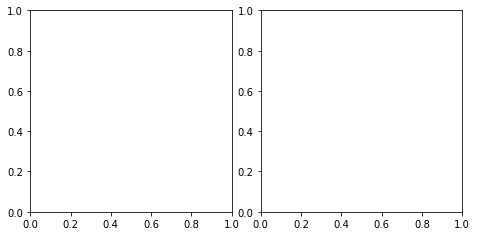

In [59]:
for i in range(13):
    fig = plt.figure(figsize=(8, 4))

    ax_u = fig.add_axes([0.1, 0.1, 0.35, 0.7])
    ax_n = fig.add_axes([0.5, 0.1, 0.35, 0.7])

    fig.text(0.5, 0.95, dset_unnormalized_list[0].predictors[i], ha="center")

    ax_u.set_title("Unnormalized")
    for ix, ds in enumerate(dset_unnormalized_list):
        if ix not in rand_idx:
            continue
        label = f"{ds.shotnr}: Disrupts: {ds.is_disruptive}"
        ax_u.plot(ds[:][0][:, i], label=label)

    ax_n.set_title("Normalized")
    for ix, ds in enumerate(dset_all):
        if ix not in rand_idx:
            continue
        label = f"{ds.shotnr}: Disrupts: {ds.is_disruptive}"
        ax_n.plot(ds[:][0][:, i], label=label)
    ax_n.legend(loc="upper right", bbox_to_anchor=(1.85, 1), borderaxespad=0.)

# Paths

The basis path where all data is searched for is given by conf["paths"]["fs_path"]. 

Directories that are searched for signals are given by conf["paths"]["signal_prepath"]





In [ ]:
my_conf

In [ ]:
my_conf["paths"]